In [3]:
import numpy as np
from matplotlib import pyplot as plt
from utils import *

In [4]:
true_trajectory, noisy_observations = generate_trajectory_nonlinear()

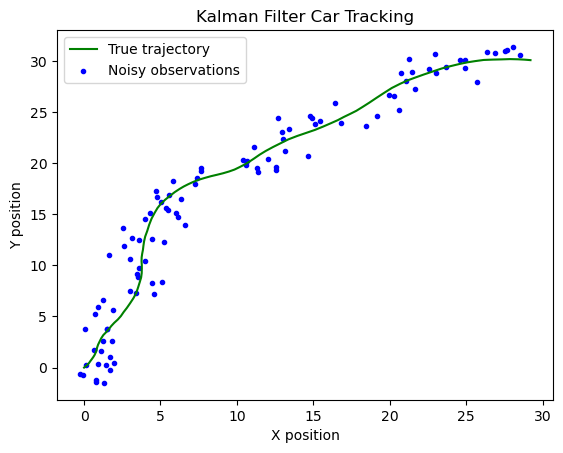

In [5]:
plt.plot(true_trajectory[:, 0], true_trajectory[:, 1], 'g-', label='True trajectory')
plt.scatter(noisy_observations[:, 0], noisy_observations[:, 1], c='b', marker='.', label='Noisy observations')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.legend()
plt.title('Kalman Filter Car Tracking')
plt.show()

In [40]:
extended_kalman_filter = EKF(f, F_jacobian, h, H_jacobian, Q, R, dim_m = 4, dim_y = 2)
state_estimates, cov_estimates = extended_kalman_filter.filter(noisy_observations)
state_estimates_smoothed, cov_estimates_smoothed = extended_kalman_filter.smoother(state_estimates, cov_estimates)

In [41]:
from matplotlib.patches import Ellipse
from scipy.linalg import eigh
from scipy.stats import chi2

cornflowerblue_alpha = (0.39215686274509803, 0.5843137254901961, 0.9294117647058824, 0.3)

def rgba_to_rgb(rgba, bg=(1, 1, 1)):
    r, g, b, a = rgba
    bg_r, bg_g, bg_b = bg
    
    # Blend the RGBA color with the background color
    r = r * a + bg_r * (1 - a)
    g = g * a + bg_g * (1 - a)
    b = b * a + bg_b * (1 - a)

    return (r, g, b)

def conf_ellipse(ax, center, covariance, alpha=0.95):
    chi2_quantile = chi2.ppf(alpha, 2)
    eigvals, eigvecs = eigh(covariance)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigvals[0] * chi2_quantile), 2 * np.sqrt(eigvals[1] * chi2_quantile)
    ell = Ellipse(xy=center, width=width, height=height, angle=angle, fill=True, facecolor=rgba_to_rgb(cornflowerblue_alpha))
    ax.add_artist(ell)

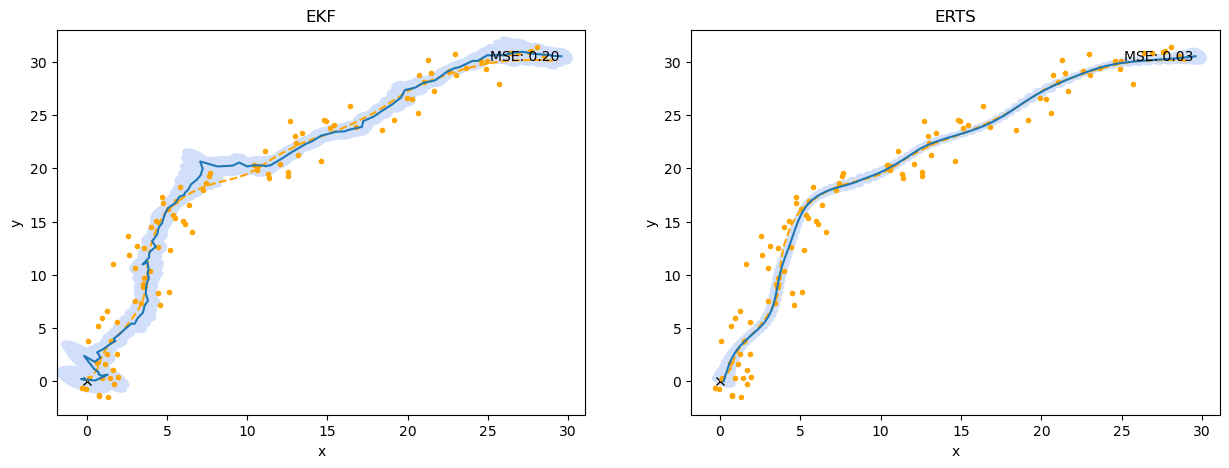

In [42]:
#Compare methods
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for k in range(2):
    ax[k].plot(true_trajectory[0, 0], true_trajectory[0, 1], 'x', color='k', label="Start")
    ax[k].plot(true_trajectory[:, 0], true_trajectory[:, 1], '--', color='orange', label="True trajectory")
    ax[k].plot(noisy_observations[:, 0], noisy_observations[:, 1], '.', color='orange', label="Noisy observations")
    ax[k].set_xlabel("x")
    ax[k].set_ylabel("y")
    
ax[0].plot(state_estimates[:, 0], state_estimates[:, 1], label="EKF")
ax[0].set_title("EKF")

ax[1].plot(state_estimates_smoothed[:, 0], state_estimates_smoothed[:, 1], label="ERTS")
ax[1].set_title("ERTS")

# Compute MSE
EKF_MSE = np.mean((true_trajectory[:, :2] - state_estimates[:, :2])**2)
ERTS_MSE = np.mean((true_trajectory[:, :2] - state_estimates_smoothed[:, :2])**2)

# Show the MSE on the plot in upper right corner
ax[0].text(0.95, 0.95, "MSE: {:.2f}".format(EKF_MSE), horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, "MSE: {:.2f}".format(ERTS_MSE), horizontalalignment='right', verticalalignment='top', transform=ax[1].transAxes)

# # 95% confidence ellipses for the KF
for i in range(0, len(state_estimates)):
    conf_ellipse(ax[0], state_estimates[i, :2], cov_estimates[i, :2, :2])
    
# # 95% confidence ellipses for the EKF
for i in range(0, len(state_estimates_smoothed)):
    conf_ellipse(ax[1], state_estimates_smoothed[i, :2], cov_estimates_smoothed[i, :2, :2])
    
plt.show()